In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs
from sklearn.preprocessing import StandardScaler

plt.style.use('fivethirtyeight')

In [2]:
def master_df(chamber):
    master = pd.DataFrame()
    fpath='../congress-data/%s/' % chamber
    files=os.listdir(fpath)
    for file in files:
        
        congress = int(file.split('_')[1].split('.')[0])
        df = pd.read_csv(fpath + file, index_col=0, parse_dates=['dob'])
        df['congress'] = congress
        
        master = master.append(df, ignore_index=True)
    
    return master

In [49]:
house = master_df('house')
senate = master_df('senate')

### Looking at House

1. Split the data from the House of Representatives by gender and isolate the number of missed votes.

In [50]:
male_reps = house[house['gender'] == 'M']
female_reps = house[house['gender'] == 'F']

male_missed = male_reps['missed_votes']
male_x = np.zeros(len(male_missed),)

female_missed = female_reps['missed_votes']
female_x = np.ones(len(female_missed))

2. Plot the initial distributions of the data.

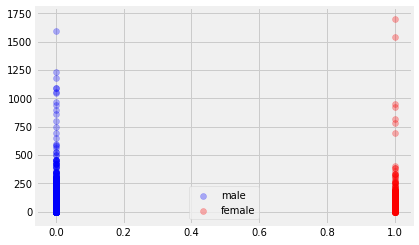

In [51]:
fig, ax = plt.subplots()
ax.scatter(male_x, male_missed, c='b', label='male', alpha=0.3)
ax.scatter(female_x, female_missed, c='r', label='female', alpha=0.3)
ax.legend();

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


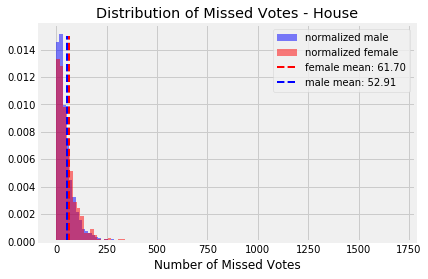

In [52]:
fig, ax = plt.subplots()

female_mean = np.mean(female_missed)
male_mean = np.mean(male_missed)

ax.hist(male_missed, color='b', label='normalized male', bins=100, normed=1, alpha=0.5)
ax.hist(female_missed, color='r', label='normalized female', bins=100, normed=1, alpha=0.5)
ax.vlines(female_mean, 0, 0.015, color='r', linestyle='--', linewidth=2, label='female mean: %.2f' % female_mean)
ax.vlines(male_mean, 0, 0.015, color='b', linestyle='--', linewidth=2, label='male mean: %.2f' % male_mean)
ax.legend()
ax.set_xlabel('Number of Missed Votes');
ax.set_title('Distribution of Missed Votes - House');

In [53]:
print('Male Sample Size: %d' % len(male_reps))
print('Female Sample Size: %d' % len(female_reps))

Male Sample Size: 5598
Female Sample Size: 1007


3. Bootstrapping to justify using a T-test

In [54]:
male_sample_mean = []
female_sample_mean = []

for i in range(10000):
    male_sample = np.random.choice(male_missed, 500)
    female_sample = np.random.choice(female_missed, 500)
    
    male_sample_mean.append(np.mean(male_sample))
    female_sample_mean.append(np.mean(female_sample))

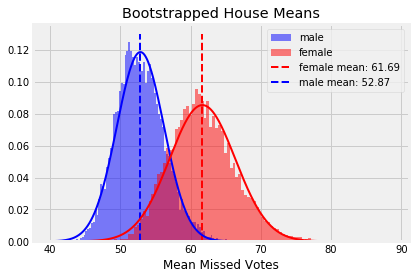

In [55]:
fig, ax = plt.subplots()

male_bootstrapped_mean = np.mean(male_sample_mean)
male_std = np.std(male_sample_mean)
female_bootstrapped_mean = np.mean(female_sample_mean)
female_std = np.std(female_sample_mean)

male_norm = scs.norm(male_bootstrapped_mean, male_std)
female_norm = scs.norm(female_bootstrapped_mean, female_std)


x = np.linspace(40, 80, 500)

ax.hist(male_sample_mean, color='b', label='male', bins=100, alpha=0.5, normed=1)
ax.hist(female_sample_mean, color='r', label='female', bins=100, alpha=0.5, normed=1)
ax.plot(x, male_norm.pdf(x), color='b', linewidth=2)
ax.plot(x, female_norm.pdf(x), color='r', linewidth=2)
ax.vlines(female_bootstrapped_mean, 0, 0.13, color='r', linestyle='--', linewidth=2, label='female mean: %.2f' % female_bootstrapped_mean)
ax.vlines(male_bootstrapped_mean, 0, 0.13, color='b', linestyle='--', linewidth=2, label='male mean: %.2f' % male_bootstrapped_mean)
ax.legend()
ax.set_title('Bootstrapped House Means')
ax.set_xlabel('Mean Missed Votes');

since the bootstrapped means are normal, and the sample sizes are sufficiently large, I can use t-tests to accept or reject my hypothesis.

In [56]:
ttest, p_val = scs.ttest_ind(male_sample_mean, female_sample_mean)
print(p_val)

0.0


4. Running our t-test

In a given session of Congress, female representatives miss 61.68 votes on average, while male representatives miss 52.91 votes on average. The question is, is this significant?

$$H_0: \mu_f = \mu_m$$
$$H_a: \mu_f > \mu_m$$

We want to run a 2-tail t-test. Our alpha threshold will be 0.05.

In [57]:
t_stat, p_val = scs.ttest_ind(male_missed, female_missed)
print(p_val)

0.0013959115090709494


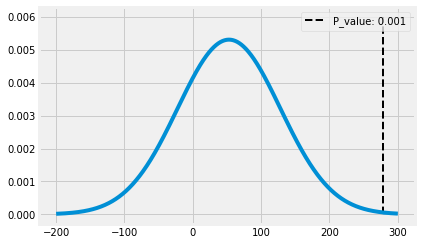

In [58]:
dist_m = scs.norm(np.mean(male_missed), np.std(male_missed))
y = dist_m.ppf(1 - p_val)
fig, ax = plt.subplots()
x = np.linspace(-200, 300, 1000)
ax.plot(x, dist_m.pdf(x))
ax.vlines(y, 0, 0.006, linestyle='dashed', linewidth=2, label='P_value: %.3f' % p_val)
fill_space = np.linspace(y, 300, 500)
ax.fill_between(fill_space, 0, dist_m.pdf(fill_space), alpha=0.5)
ax.legend();

In [59]:
# Removing Pelosi
female_reps_no_speaker = female_reps[(female_reps['leadership_role'] != 'Speaker of the House')]['missed_votes']
male_reps_no_speaker = male_reps[(male_reps['leadership_role'] != 'Speaker of the House')]['missed_votes']

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


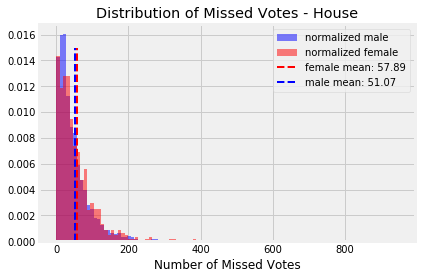

In [62]:
fig, ax = plt.subplots()

female_mean = np.mean(female_reps_no_speaker)
male_mean = np.mean(male_reps_no_speaker)

ax.hist(male_reps_no_speaker, color='b', label='normalized male', bins=100, normed=1, alpha=0.5)
ax.hist(female_reps_no_speaker, color='r', label='normalized female', bins=100, normed=1, alpha=0.5)
ax.vlines(female_mean, 0, 0.015, color='r', linestyle='--', linewidth=2, label='female mean: %.2f' % female_mean)
ax.vlines(male_mean, 0, 0.015, color='b', linestyle='--', linewidth=2, label='male mean: %.2f' % male_mean)
ax.legend()
ax.set_xlabel('Number of Missed Votes');
ax.set_title('Distribution of Missed Votes - House');

In [63]:
t_stat, p_val = scs.ttest_ind(male_reps_no_speaker, female_reps_no_speaker)
print(p_val)

0.0015622964773491469


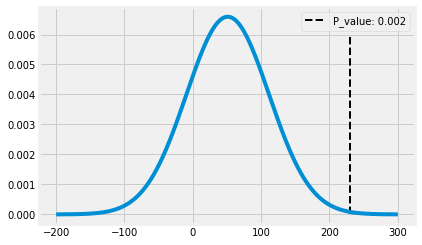

In [65]:
dist_m = scs.norm(np.mean(male_reps_no_speaker), np.std(male_reps_no_speaker))
y = dist_m.ppf(1 - p_val)
fig, ax = plt.subplots()
x = np.linspace(-200, 300, 1000)
ax.plot(x, dist_m.pdf(x))
ax.vlines(y, 0, 0.006, linestyle='dashed', linewidth=2, label='P_value: %.3f' % p_val)
fill_space = np.linspace(y, 300, 500)
ax.fill_between(fill_space, 0, dist_m.pdf(fill_space), alpha=0.5)
ax.legend();

Conclusion: Female reps miss more votes on average than male reps, and it is statistically significant, even when accounting for the Speaker of the House

### Looking at Senate

In [13]:
male_senators = senate[senate['gender'] == 'M']
female_senators = senate[senate['gender'] == 'F']

male_missed = male_senators['missed_votes']
male_x = np.zeros(len(male_missed),)

female_missed = female_senators['missed_votes']
female_x = np.ones(len(female_missed))

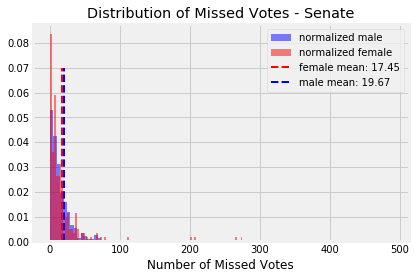

In [14]:
fig, ax = plt.subplots()

female_mean = np.mean(female_missed)
male_mean = np.mean(male_missed)

ax.hist(male_missed, color='b', label='normalized male', bins=100, normed=1, alpha=0.5)
ax.hist(female_missed, color='r', label='normalized female', bins=100, normed=1, alpha=0.5)
ax.vlines(female_mean, 0, 0.07, color='r', linestyle='--', linewidth=2, label='female mean: %.2f' % female_mean)
ax.vlines(male_mean, 0, 0.07, color='b', linestyle='--', linewidth=2, label='male mean: %.2f' % male_mean)
ax.legend()
ax.set_xlabel('Number of Missed Votes')
ax.set_title('Distribution of Missed Votes - Senate');

In a given session of Congress, female senators miss 17.45 votes on average, while male representatives miss 19.67 votes on average. The question is, is this significant?

$$H_0: \mu_f = \mu_m$$
$$H_a: \mu_f > \mu_m$$

We want to run a 2-tail t-test. Our alpha threshold will be 0.05.

In [15]:
t_stat, p_val = scs.ttest_ind(male_missed, female_missed)
print(p_val)

0.3935197322521503


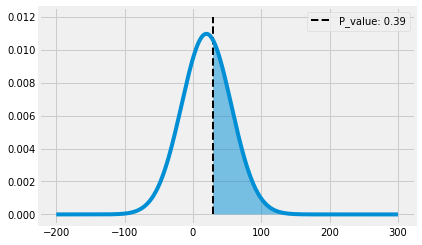

In [16]:
dist_m = scs.norm(np.mean(male_missed), np.std(male_missed))
y = dist_m.ppf(1 - p_val)
fig, ax = plt.subplots()
x = np.linspace(-200, 300, 1000)
ax.plot(x, dist_m.pdf(x))
ax.vlines(y, 0, 0.012, linestyle='dashed', linewidth=2, label='P_value: %.2f' % p_val)

fill_space = np.linspace(y, 300, 500)
ax.fill_between(fill_space, 0, dist_m.pdf(fill_space), alpha=0.5)
ax.legend();

Conclusion: male senators miss more votes than female senators on average.